In [15]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import math
pd.set_option("display.max_rows", 100)

In [16]:
df = get_price(order_book_ids = "600050.XSHG",start_date = "20200101",end_date = "20230614")
df = df.reset_index()
df["5_day_avg"] = df["close"].rolling(5).mean()
df["10_day_avg"] = df["close"].rolling(10).mean()
df.index = df["date"]

In [17]:
df1 = pd.DataFrame(index = df["date"])
df1["5_day_avg"] = df["5_day_avg"] 
df1["10_day_avg"]  = df["10_day_avg"] 
df1["close"] = df["close"]
buy_filter = (df1["5_day_avg"]>df1["10_day_avg"]) & (df1["5_day_avg"].shift(1).fillna(0.) < df1["10_day_avg"].shift(1).fillna(0.))
sell_filter = (df1["5_day_avg"]<df1["10_day_avg"]) & (df1["5_day_avg"].shift(1).fillna(0.) > df1["10_day_avg"].shift(1).fillna(0.))

In [18]:
temp1 = df1.where(buy_filter).reset_index().dropna()
temp1["action"] = "buy"
temp2 = df1.where(sell_filter).reset_index().dropna()
temp2["action"] = "sell"

In [19]:
temp1 = temp1.reset_index()
temp2 = temp2.reset_index()

In [20]:
day_filter_1 = ((temp1["index"]-temp1["index"].shift(1).fillna(0.))>=10)
day_filter_2 = ((temp2["index"]-temp2["index"].shift(1).fillna(0.))>=10)
temp1 = temp1.where(day_filter_1).dropna()
temp2 = temp2.where(day_filter_2).dropna()
new = pd.concat([temp1,temp2]).sort_values(by = "date")

In [21]:
action_filter = (new["action"] != new["action"].shift(1))

In [22]:
final = new.where(action_filter).dropna()

In [23]:
final = final.reset_index(drop = True)
final = final.drop("index",axis=1)
final = final.drop(0)

In [24]:
buy = pd.DataFrame(final[final["action"]=="buy"])
sell = pd.DataFrame(final[final["action"]=="sell"])

Text(0.5, 1.0, '個股買進賣出圖')

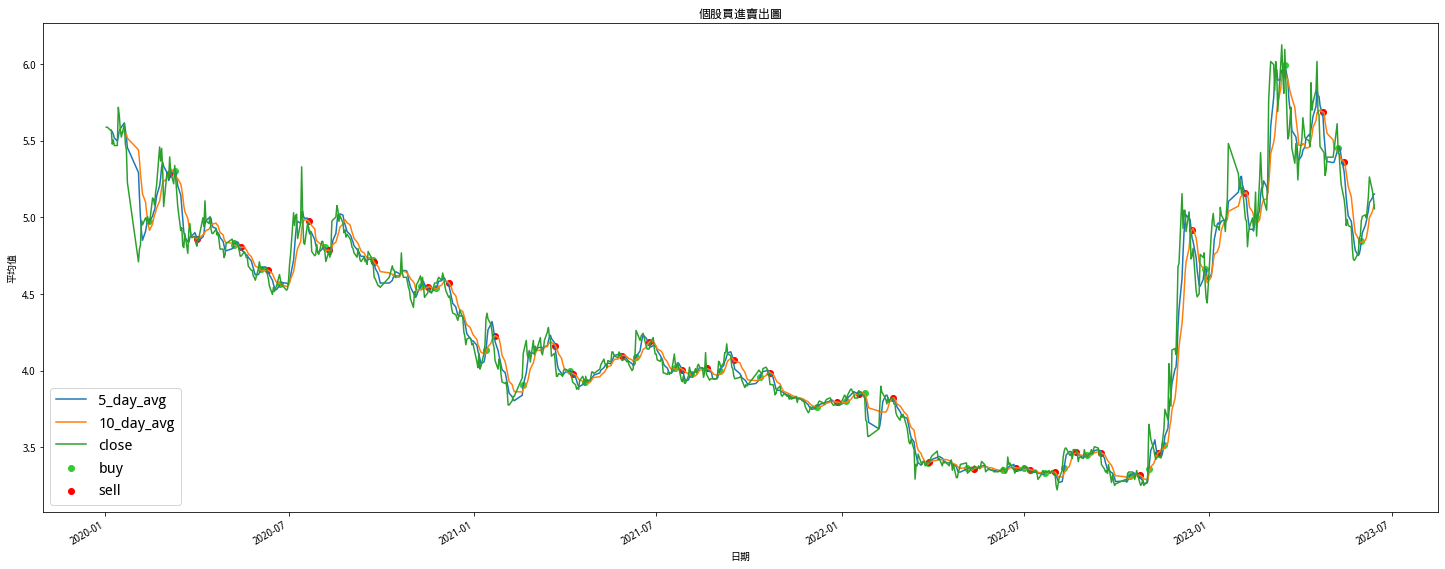

In [25]:
ax = df1.plot(figsize = (25,10))
# .reset_index().groupby(["buy","date"]).sum().reset_index()
plt.scatter(buy["date"],buy["5_day_avg"], color = "limegreen",label = "buy")
plt.scatter(sell["date"],sell["10_day_avg"], color = "red",label = "sell")
ax.legend(prop={'size':15})
ax.set_xlabel("日期")
ax.set_ylabel("平均值")
ax.set_title("個股買進賣出圖")

In [26]:
buy["quantity"] = 50000/buy["close"]
buy["quantity"] = (buy["quantity"]// 100) * 100
dates = df["close"].to_frame().reset_index()

In [27]:
results = pd.concat([buy,sell]).sort_values(by = "date")
results = results.ffill(axis = "rows")

In [28]:
results = results.sort_values(by = "date")
results = pd.concat([results,dates]).drop_duplicates(["date","close"]).sort_values(by="date")

In [29]:
results

,date,5_day_avg,10_day_avg,close,action,quantity
0,2020-01-02,NaN,NaN,5.5886,NaN,NaN
1,2020-01-03,NaN,NaN,5.5886,NaN,NaN
2,2020-01-06,NaN,NaN,5.5701,NaN,NaN
3,2020-01-07,NaN,NaN,5.5701,NaN,NaN
4,2020-01-08,NaN,NaN,5.4775,NaN,NaN
...,...,...,...,...,...,...
831,2023-06-08,NaN,NaN,5.1348,NaN,NaN
832,2023-06-09,NaN,NaN,5.2636,NaN,NaN
833,2023-06-12,NaN,NaN,5.1744,NaN,NaN
834,2023-06-13,NaN,NaN,5.1249,NaN,NaN


In [30]:
results = results.drop(["5_day_avg","10_day_avg"],axis=1)
results = results.reset_index(drop = True)

In [31]:
a = results["quantity"].ffill()
b = results["quantity"].bfill()
results["quantity"] = results["quantity"].mask(a == b, a)

In [32]:
buy_indices = results[results['action'] == 'buy'].index
sell_indices = results[results['action'] == 'sell'].index

for buy_index, sell_index in zip(buy_indices, sell_indices):
    results.loc[buy_index:sell_index, 'action'] = results.loc[buy_index:sell_index, 'action'].fillna('hold')

In [33]:
results.index = results["date"]
results = results.drop("date",axis=1)

In [34]:
buy_indices = results[results['action'] == 'buy'].index
sell_indices = results[results['action'] == 'sell'].index

for buy_index, sell_index in zip(buy_indices, sell_indices):
    filtered = pd.DataFrame(results.loc[buy_index:sell_index,:])
    price_change = (filtered["close"] / filtered["close"].shift(1)) - 1
    results.loc[buy_index:sell_index,"price_change"] = price_change
    

In [35]:
filtered = results["price_change"].to_frame("cumsum_results")
filtered = filtered.apply(lambda x: np.expm1(np.log1p(x).cumsum()))

In [36]:
final_results = pd.merge(results, filtered, on="date", how="left")
last = final_results['cumsum_results'].last_valid_index()
final_results['cumsum_results'].loc[:last] = final_results['cumsum_results'].loc[:last].ffill()

/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [37]:
np.expm1(np.log1p(final_results['price_change'])).sum()

0.08348866347551631

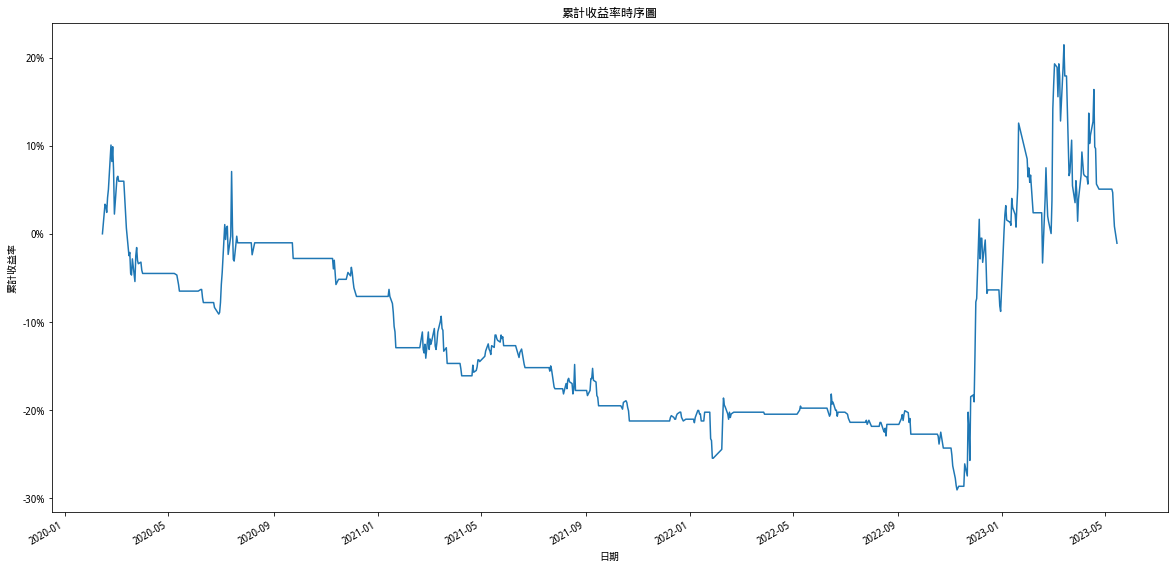

In [38]:
ax = final_results["cumsum_results"].plot(figsize = (20,10))
ax.set_xlabel("日期")
ax.set_ylabel("累計收益率")
ax.set_title("累計收益率時序圖")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

In [39]:
final_results["cumsum_results"].dropna().iloc[-1]

-0.010687801681587422

In [40]:
monthly_basis = results["price_change"].resample('M').apply(lambda x: np.expm1(np.log1p(x).sum())).to_frame("results")
monthly_basis['month'] = monthly_basis.index.strftime("%Y-%m")

In [41]:
# result.index.strftime('%Y-%m')

In [42]:
a = results['price_change'].groupby(results.index.strftime('%Y-%m')).agg(lambda x: np.expm1(np.log1p(x).sum()))
np.expm1(np.log1p(a).sum())

-0.010687801681587485

In [43]:
np.expm1(np.log1p(monthly_basis['results']).sum())

-0.010687801681587485

In [44]:
cumsum_results = final_results["cumsum_results"].dropna().to_frame("results")

In [45]:
averages = df1[["5_day_avg","10_day_avg"]]

In [46]:
close = df1["close"].to_frame("close")

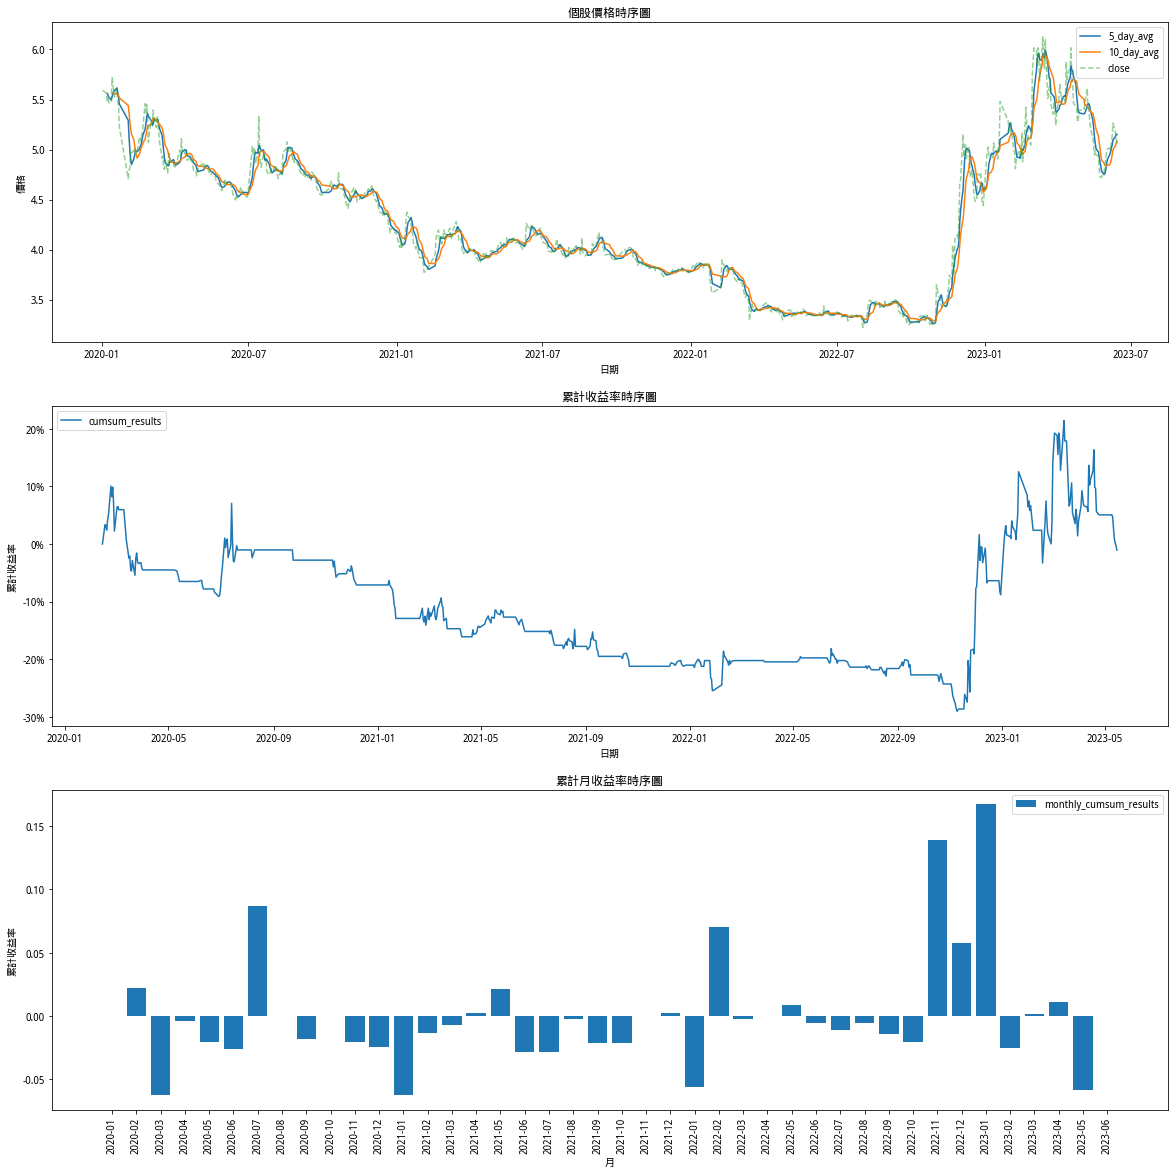

In [47]:
fig = plt.figure(figsize = (20,20))

ax = plt.subplot(311)
ax.plot(averages["5_day_avg"],label = "5_day_avg")
ax.plot(averages["10_day_avg"],label = "10_day_avg")
ax.plot(close,linestyle="dashed",label = "close",alpha = 0.5)
ax.set_xlabel("日期")
ax.set_ylabel("價格")
ax.set_title("個股價格時序圖")
ax.legend()


ax = plt.subplot(312)
ax.plot(cumsum_results,label = "cumsum_results")
ax.set_xlabel("日期")
ax.set_ylabel("累計收益率")
ax.set_title("累計收益率時序圖")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.legend()


ax = plt.subplot(313)
ax.bar(monthly_basis.index.astype(str),monthly_basis["results"],label = "monthly_cumsum_results")
ax.set_xticklabels(labels = monthly_basis["month"], rotation =90)
ax.set_xlabel("月")
ax.set_ylabel("累計收益率")
ax.set_title("累計月收益率時序圖")
ax.legend()




In [48]:
np.expm1(np.log1p(results["price_change"]).sum())

-0.010687801681587526